# Extracción de datos

## Imports para extracción

In [1]:
import pandas as pd 
import numpy as np
import oandapy as opy
import psycopg2
import logging
import os
from datetime import datetime as dt
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

Extraemos datos de precios (Oanda) para el instrumento que elijamos y de twitter (Base de datos de Prophets)

### Oanda

In [25]:
pricediff = True # Precios o differencia de precios
logreturns = True # Diferencia en logaritmos de los precios
candleformat = 'midpoint' # ['midpoint', 'bidask']
instrument = 'USD_JPY'
granularity = 'M5'
d1 = '2008-01-01'
min_window = 5
step = int(60/min_window)
d2 = str(dt.now())[:10]
oanda = opy.API(environment='live')

In [26]:
# Extraemos datos cada 2 días (por simplicidad)

dates = pd.date_range(start=d1, end=d2, freq='2D')
df = pd.DataFrame()

print('Se van a descargar {} días'.format(2*len(dates)))
print('Descargando:')

pbar = tqdm(total=len(dates) - 1)

for i in range(0, len(dates) - 1):
    # Oanda toma las fechas en este formato
    d1 = str(dates[i]).replace(' ', 'T')
    d2 = str(dates[i+1]).replace(' ', 'T')
    try:
        # Concatenamos cada día en el dataframe
        data = oanda.get_history(instrument=instrument, 
                                 candleFormat=candleformat,
                                 start=d1, 
                                 end=d2, 
                                 granularity=granularity)
        df = df.append(pd.DataFrame(data['candles']))
        pbar.update(1)
    except:
        pass
pbar.close()
date = pd.DatetimeIndex(df['time'], tz='UTC')
df['date'] = date

Se van a descargar 3962 días
Descargando:


HBox(children=(IntProgress(value=0, max=1980), HTML(value='')))

In [4]:
drops = ['complete', 'time']
df = df.drop(drops, axis=1)
df = df[100:] # Falla en API
df = df.reset_index(drop=True)

In [5]:
if candleformat == 'bidask':
    
    if pricediff:
        
        prices = [j for j in df.columns if j not in ['date', 'volume']]
        
        if logreturns:
            for i in prices:
                df['diff ' + i] = np.log(df[i]).diff(1)
        
        else:
            
            for i in prices:
                df['diff ' + i] = df[i] - df[i].shift(1)
        df = df.drop(prices, axis=1)

        open_bid = ['diff openBid' + str(min_window*(i+1)) for i in range(step)]
        open_ask = ['diff openAsk' + str(min_window*(i+1)) for i in range(step)]
        close_bid = ['diff closeBid' + str(min_window*(i+1)) for i in range(step)]
        close_ask = ['diff closeAsk' + str(min_window*(i+1)) for i in range(step)]
        low_bid = ['diff lowBid' + str(min_window*(i+1)) for i in range(step)]
        low_ask = ['diff lowAsk' + str(min_window*(i+1)) for i in range(step)]
        high_bid = ['diff highBid' + str(min_window*(i+1)) for i in range(step)]
        high_ask = ['diff highAsk' + str(min_window*(i+1)) for i in range(step)]
        volume = ['volume' + str(min_window*(i+1)) for i in range(step)]

        shifts = list(range(1,step+1))

        for v, ob, oa, cb, ca, lb, la, hb, ha, s in zip(volume,
                                                     open_bid, 
                                                     open_ask, 
                                                     close_bid, 
                                                     close_ask, 
                                                     low_bid, 
                                                     low_ask, 
                                                     high_bid, 
                                                     high_ask, 
                                                     shifts):
            df[v] = df['volume'].shift(s)
            df[ob] = df['diff openBid'].shift(s)
            df[oa] = df['diff openAsk'].shift(s)
            df[cb] = df['diff closeBid'].shift(s)
            df[ca] = df['diff closeAsk'].shift(s)
            df[lb] = df['diff lowBid'].shift(s)
            df[la] = df['diff lowAsk'].shift(s)
            df[hb] = df['diff highBid'].shift(s)
            df[ha] = df['diff highAsk'].shift(s)

    else:

        open_bid = ['openBid' + str(min_window*(i+1)) for i in range(step)]
        open_ask = ['openAsk' + str(min_window*(i+1)) for i in range(step)]
        close_bid = ['closeBid' + str(min_window*(i+1)) for i in range(step)]
        close_ask = ['closeAsk' + str(min_window*(i+1)) for i in range(step)]
        low_bid = ['lowBid' + str(min_window*(i+1)) for i in range(step)]
        low_ask = ['lowAsk' + str(min_window*(i+1)) for i in range(step)]
        high_bid = ['highBid' + str(min_window*(i+1)) for i in range(step)]
        high_ask = ['highAsk' + str(min_window*(i+1)) for i in range(step)]
        volume = ['volume' + str(min_window*(i+1)) for i in range(step)]

        shifts = list(range(1,step+1))

        for v, ob, oa, cb, ca, lb, la, hb, ha, s in zip(volume,
                                                     open_bid, 
                                                     open_ask, 
                                                     close_bid, 
                                                     close_ask, 
                                                     low_bid, 
                                                     low_ask, 
                                                     high_bid, 
                                                     high_ask, 
                                                     shifts):
            df[v] = df['volume'].shift(s)
            df[ob] = df['openBid'].shift(s)
            df[oa] = df['openAsk'].shift(s)
            df[cb] = df['closeBid'].shift(s)
            df[ca] = df['closeAsk'].shift(s)
            df[lb] = df['lowBid'].shift(s)
            df[la] = df['lowAsk'].shift(s)
            df[hb] = df['highBid'].shift(s)
            df[ha] = df['highAsk'].shift(s)
else:  
    
    if pricediff:

        prices = [j for j in df.columns if j not in ['date', 'volume']]
        
        if logreturns:
            for i in prices:
                df['diff ' + i] = np.log(df[i]).diff(1)
        
        else:
            
            for i in prices:
                df['diff ' + i] = df[i] - df[i].shift(1)
                
        df = df.drop(prices, axis=1)

        open_ = ['diff openMid' + str(min_window*(i+1)) for i in range(step)]
        close = ['diff closeMid' + str(min_window*(i+1)) for i in range(step)]
        low = ['diff lowMid' + str(min_window*(i+1)) for i in range(step)]
        high = ['diff highMid' + str(min_window*(i+1)) for i in range(step)]
        volume = ['volume' + str(min_window*(i+1)) for i in range(step)]

        shifts = list(range(1,step+1))

        for v, o, c, l, h, s in zip(volume,
                                     open_, 
                                     close, 
                                     low, 
                                     high, 
                                     shifts):
            df[v] = df['volume'].shift(s)
            df[o] = df['diff openMid'].shift(s)
            df[c] = df['diff closeMid'].shift(s)
            df[l] = df['diff lowMid'].shift(s)
            df[h] = df['diff highMid'].shift(s)

    else:

        open_ = ['openMid' + str(min_window*(i+1)) for i in range(step)]
        close = ['closeMid' + str(min_window*(i+1)) for i in range(step)]
        low = ['lowMid' + str(min_window*(i+1)) for i in range(step)]
        high = ['highMid' + str(min_window*(i+1)) for i in range(step)]
        volume = ['volume' + str(min_window*(i+1)) for i in range(step)]

        shifts = list(range(1,step+1))

        for v, o, c, l, h, s in zip(volume,
                                     open_, 
                                     close, 
                                     low, 
                                     high, 
                                     shifts):
            df[v] = df['volume'].shift(s)
            df[o] = df['openMid'].shift(s)
            df[c] = df['closeMid'].shift(s)
            df[l] = df['lowMid'].shift(s)
            df[h] = df['highMid'].shift(s)


In [6]:
df = df[step+1:]

In [7]:
df['date'] = df['date'].astype(str)
df['d2'] = df['date'].str[14:]
df = df[df['d2'] == '00:00+00:00']

In [8]:
df = df.reset_index(drop=True)
df = df.drop('d2', axis=1)

In [9]:
fake_drop = volume + ['volume', 'date']
df['H'] = df.drop(fake_drop, 1).max(axis=1)
df['L'] = df.drop(fake_drop, 1).min(axis=1)
df['vol'] = df[volume].sum(axis=1)

In [10]:
df['date'] = df['date'].str[:13]
pr = df.copy()

### Twitter

In [11]:
def db_conn():
    """
    Método que hace la conexión a la base de datos
    Args:
        conn_creds(dict): diccionario donde vienen las credenciales de
        la conexión a la base de datos
                         host(str): host que hospeda a la base de datos
                         port(str): puerto donde está disponible la base de datos
                         user(str): usuario con el que se hará la conexión
                         password(str): contraseña del usuario en la BD
                         database(str): nombre de la base de datos
    Returns:
        conn: objeto que contiene la sesión de una conexión a la BD
    """
    try:
        conn = psycopg2.connect(
            host=os.environ['ID_HOST'],
            port=os.environ['ID_PORT'],
            user=os.environ['ID_USER'],
            password=os.environ['ID_PASSWORD'],
            database=os.environ['ID_DB'],
        )
    except Exception as error:
        logging.error(error)

    return conn

def download(conn, query):
    """
    Descarga datos de la base de datos según la consulta insertada
    Args:
        conn (connection): objeto que contiene la sesión de una
                           conexión a la base de datos
        query (str): String donde se define el query a ejecutarse
    Returns:
        df (DataFrame): Tabla con los datos que elegimos
    """
    try:
        df = pd.read_sql(query, conn)
        conn.commit()
    finally:
        conn.close()


    return df

In [12]:
conn = db_conn()
query = '''SELECT date_trunc('hour',cast(date as timestamp)), avg(polarity) polarity, avg(subjectivity) subjectivity
           FROM tweets 
           WHERE
           tweet like '%inflation%' OR
            tweet like '%dollar%' OR
            tweet like '%FED%' OR 
            tweet like '%rates%' OR
            tweet like '%usd%' OR
            tweet like '%usdjpy%' OR
            tweet like '%yen%' OR
            tweet like '%markets' OR
            tweet like '%forex%' OR
            tweet like '%fx%' OR
            tweet like '%China%' OR
            tweet like '%tradewar%' OR
            tweet like '%trade%' OR
            tweet like '%business%' OR
            tweet like '%economy%' OR
            tweet like '%Dow%' OR
            tweet like '%Nasdaq%' OR 
            tweet like '%Russia%' OR
            tweet like '%BOJ%' OR
            tweet like '%central bank%' OR
            tweet like '%economic calendar%' OR
            tweet like '%U.S.%' OR
            tweet like '%Brexit%' OR
            tweet like '%pound%' OR
            tweet like '%gains%' OR
            tweet like '%bearish%' OR
            tweet like '%bullish%' OR
            tweet like '%forecast%' OR
            tweet like '%Donald%' OR
            tweet like '%Trump%' OR
            tweet like '%fixed income%' OR
            tweet like '%capital%' OR
            tweet like '%Wall Street%' OR
            tweet like '%debt%' OR
            tweet like '%EU%' OR
            tweet like '%reshaping%' OR
            tweet like '%condifence%' OR
            tweet like '%indicator%' OR
            tweet like '%indicators%' OR
            tweet like '%policies%' OR
            tweet like '%gold%' OR
            tweet like '%commodities%' OR
            tweet like '%technical%' OR
            tweet like '%canadian%' OR
            tweet like '%unemployment%' OR
            tweet like '%ISM%' OR
            tweet like '%housing%' OR
            tweet like '%bubble%' OR
            tweet like '%recession%' OR
            tweet like '%PMI%' OR
            tweet like '%oil%' OR
            tweet like '%jobs%' OR
            tweet like '%yield%' OR
            tweet like '%crude%' OR
            tweet like '%ECB%' OR
            tweet like '%jobless%' OR
            tweet like '%FOMC%' OR
            tweet like '%GDP%' OR
            tweet like '%manufacturing%' OR
            tweet like '%PPI%' OR
            tweet like '%Industrial%' OR
            tweet like '%CPI%' OR
            tweet like '%Core CPI%' OR
            tweet like '%employment%' OR
            tweet like '%retail%' OR
            tweet like '%index%' 
        
GROUP BY date_trunc('hour',cast(date as timestamp)) 
order by date_trunc DESC'''
tw = download(conn, query)

In [13]:
tw['date_trunc'] = tw['date_trunc'] + timedelta(hours=5)
tw['date_trunc'] = tw['date_trunc'].astype(str)
tw['date_trunc'] = tw['date_trunc'].str[:13]

In [14]:
df = pd.merge(pr, tw, left_on='date', right_on='date_trunc', how='left')
df = df.drop(['date', 'date_trunc'], axis=1)

In [15]:
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')

### VIF

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif(X):
    """
    Nos da el factor de inflación de la varianza de cada variable independiente

    Args:
        X (DataFrame): DataFrame con datos de nuestras variables independientes
    Returns:
        vif (DataFrame): DataFrame con el factor de inflación de la varianza
                         de cada variable
    """
    vif = pd.DataFrame()
    X['intercept'] = 1
    x = X.values
    vif['vif'] = [variance_inflation_factor(x, i) for i in range(x.shape[1])]
    vif['feature'] = X.columns

    return vif

In [17]:
DF = df.copy()

In [30]:
df = DF.copy()

In [18]:
if pricediff:
    dontdrop = ['diff closeMid', 'diff highMid', 'diff lowMid', 'vol']
else:
    dontdrop = ['closeMid', 'highMid', 'lowMid', 'vol']
    
dropping = [1, 2]

while len(dropping) >= 2:
    
    vif = get_vif(df)
    svif = vif.sort_values('vif').reset_index(drop=True)
    display(svif)
    dropping = svif[svif['vif'] >= 100]
    try:
        vif_drops = list(dropping.sample(n=int(len(dropping)/2))['feature'].values)
        vif_drops = [i for i in vif_drops if i not in dontdrop]
        df = df.drop(vif_drops, axis=1)   
    except:
        display(svif)
     

/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,vif,feature
0,1.043157,polarity
1,1.049242,subjectivity
2,2.874846,H
3,3.161250,L
4,4.475564,volume
5,4.821970,diff openMid60
6,5.278796,diff highMid
7,5.427012,diff lowMid
8,5.836260,intercept
9,6.424880,diff lowMid60


,vif,feature
0,1.042883,polarity
1,1.049073,subjectivity
2,2.857803,H
3,3.138388,L
4,4.348472,diff openMid60
5,4.435439,volume
6,4.512941,diff lowMid35
7,4.609000,diff highMid40
8,4.736674,diff highMid20
9,4.786704,diff lowMid40


In [19]:
df.head()

,volume,diff closeMid,diff highMid,diff lowMid,diff openMid,volume5,diff openMid5,diff closeMid5,diff lowMid5,diff highMid5,diff openMid10,diff closeMid10,diff lowMid10,diff highMid10,diff closeMid15,diff lowMid15,diff highMid15,volume20,diff openMid20,diff lowMid20,diff highMid20,volume25,diff openMid25,diff lowMid25,diff highMid25,diff closeMid30,diff lowMid30,diff highMid30,volume35,diff closeMid35,diff lowMid35,diff highMid35,diff openMid40,diff lowMid40,diff highMid40,diff openMid45,diff lowMid45,diff highMid45,volume50,diff openMid50,diff lowMid50,diff highMid50,diff openMid55,diff closeMid55,diff lowMid55,diff highMid55,volume60,diff openMid60,diff closeMid60,diff lowMid60,diff highMid60,H,L,vol,polarity,subjectivity,intercept
0,16,-0.000474,0.000000,-0.000313,0.000179,22.0,0.000161,0.000161,0.000224,0.000152,-0.000340,0.000152,-0.000045,-0.000134,-0.000420,-0.000376,-0.000286,18.0,0.000000,0.000000,0.000000,19.0,0.000045,-0.000268,-0.000045,0.000000,0.000134,0.000045,37.0,0.000000,-0.000179,-0.000134,0.000045,0.000125,0.000134,0.000045,0.000063,0.000018,37.0,0.000000,-0.000009,0.000036,0.000089,0.000000,0.000224,0.000036,33.0,0.000510,0.000089,0.000313,-0.000223,0.000510,-0.000474,314.0,-0.2,0.25,1
1,11,-0.000179,0.000000,-0.000089,0.000000,16.0,-0.000045,0.000000,-0.000081,-0.000089,0.000179,0.000000,0.000125,0.000045,0.000179,0.000134,0.000134,24.0,-0.000358,0.000045,-0.000268,33.0,0.000224,-0.000134,0.000000,0.000224,0.000000,0.000152,26.0,0.000000,-0.000081,-0.000152,0.000045,-0.000170,-0.000179,-0.000072,0.000000,0.000134,17.0,0.000045,0.000000,-0.000027,-0.000492,0.000027,0.000000,-0.000376,16.0,0.000179,-0.000474,-0.000313,0.000000,0.000224,-0.000492,264.0,-0.2,0.25,1
2,44,0.000045,-0.000135,0.000386,0.000538,79.0,0.000539,0.000538,0.000718,0.000763,-0.000898,0.000494,-0.000045,-0.000314,-0.000727,-0.000826,-0.001031,105.0,-0.000896,-0.001184,-0.001030,80.0,-0.000090,-0.000994,-0.000313,0.000000,0.000179,0.000134,31.0,-0.000313,-0.000403,-0.000090,-0.000179,0.000045,-0.000090,-0.000089,-0.000269,-0.000179,19.0,-0.000045,0.000045,0.000045,-0.000134,0.000000,-0.000134,-0.000134,11.0,0.000000,-0.000179,-0.000089,0.000000,0.000763,-0.001184,587.0,-0.2,0.25,1
3,63,0.000224,-0.000090,-0.000054,-0.000045,56.0,0.000045,0.000000,0.000054,0.000179,0.000269,0.000000,0.000224,0.000090,0.000224,0.000090,0.000045,42.0,-0.000224,-0.000090,0.000135,33.0,-0.000090,-0.000179,-0.000179,0.000000,0.000090,0.000045,25.0,0.000000,0.000000,-0.000457,0.000045,-0.000314,-0.000036,-0.000072,0.000314,0.000242,72.0,-0.000135,-0.000386,-0.000179,0.000027,-0.000242,0.000000,-0.000018,44.0,0.000538,0.000045,0.000386,-0.000135,0.000538,-0.000457,533.0,-0.2,0.25,1
4,110,0.000805,0.001029,0.000761,0.000716,88.0,0.000224,0.000689,0.000251,0.000627,0.000538,0.000161,0.000466,0.000224,0.000538,-0.000090,0.000134,49.0,0.000090,-0.000224,-0.000027,60.0,-0.000090,0.000045,-0.000242,-0.000045,0.000448,0.000358,52.0,0.000538,-0.000009,-0.000403,0.000502,-0.000305,0.000045,0.000466,0.000403,0.000448,59.0,0.000502,0.000493,0.000385,0.000188,0.000511,0.000224,0.000601,63.0,-0.000045,0.000224,-0.000054,-0.000090,0.001029,-0.000941,736.0,-0.2,0.25,1


# Modelos

## Imports para modelos

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tpot import TPOTClassifier, TPOTRegressor
from sklearn.metrics import mean_squared_error

/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [21]:
def train_test(df, response, train_size=0.75, time_series=False, scaling=None):
    """
    Regresa train y test sets

    Args:
        df (DataFrame): Datos listos para el modelo
        response (str): Variable respuesta
        train_size (float): % Train Size
        time_series (boolean): Si es serie de tiempo o no
        scaling (str): ['standard', 'minmax', 'maxabs', 'robust', 'quantile']
    Returns:
        X_train (Array): conjunto de datos de entrenamiento (indep)
        X_test (Array): conjunto de datos de prueba (indep)
        y_train (Array): conjunto de datos de entrenamiento (dep)
        y_test (Array): conjunto de datos de prueba (dep)
    """

    data = df.copy()
    X = data.drop(response, 1)
    y = data[response]

    logging.info('X columns')
    logging.info(list(X.columns))
    logging.info('Response')
    logging.info(response)

    if time_series:
        trainsize = int(train_size*len(X))
        X_train = X[:trainsize].values
        X_test = X[trainsize:].values
        y_train = y[:trainsize].values
        y_test = y[trainsize:].values

    else:
        X_train, X_test, y_train, y_test = train_test_split(X.values,
                                                            y.values,
                                                            random_state=0,
                                                            train_size=train_size)
    if scaling == 'standard':
        scaler = preprocessing.StandardScaler()
    if scaling == 'minmax':
        scaler = preprocessing.MinMaxScaler()
    if scaling == 'maxabs':
        scaler = preprocessing.MaxAbsScaler()
    if scaling == 'robust':
        scaler = preprocessing.RobustScaler()
    if scaling == 'quantile':
        scaler = preprocessing.QuantileTransformer()

    if scaling != None:
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

def tpotclass(X_train, y_train):
    """
    Usando TPOT (Tree-Based Pipeline Optimization Tool), librería de AutoML,
    genera el "mejor" modelo de clasificación automáticamente
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        tpotmod (modelo): Modelo de clasificación generado con TPOT
    """
    pipeline_optimizer = TPOTClassifier(generations=5,
                                        population_size=50,
                                        cv=5,
                                        random_state=42,
                                        verbosity=2,
                                        n_jobs=4)
    tpotmod = pipeline_optimizer.fit(X_train, y_train)

    return tpotmod

def tpotreg(X_train, y_train):
    """
    Usando TPOT (Tree-Based Pipeline Optimization Tool), librería de AutoML,
    genera el "mejor" modelo de regresión automáticamente
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        tpotmod (modelo): Modelo de regresión generado con TPOT
    """

    pipeline_optimizer = TPOTRegressor(generations=5,
                                       population_size=50,
                                       cv=5,
                                       random_state=42,
                                       verbosity=2,
                                       n_jobs=4)
    tpotmod = pipeline_optimizer.fit(X_train, y_train)

    return tpotmod

def logreg(X_train, y_train):
    """
    Calcula modelo de Regresión Logística
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        logreg (modelo): Regresión Logística
    """
    try:
        # Si la matriz es singular va a dar error
        log = sm.Logit(y_train, X_train)
        logreg_model = log.fit()
    except Exception as e:
        # Intentamos con la matriz hessiana
        print(e)
        log = sm.Logit(y_train, X_train)
        logreg_model = log.fit(method='bfgs')

    return logreg_model

def linreg(X_train, y_train):
    """
    Calcula modelo de Regresión Lineal
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        linreg_model (modelo): Regresión Lineal
    """
    linreg = sm.OLS(y_train, X_train)
    linreg_model = linreg.fit()

    return linreg_model

#### Creación de modelos

In [23]:
DF = df.copy()

,volume,diff closeMid,diff highMid,diff lowMid,diff openMid,volume5,diff openMid5,diff closeMid5,diff lowMid5,diff highMid5,diff openMid10,diff closeMid10,diff lowMid10,diff highMid10,diff closeMid15,diff lowMid15,diff highMid15,volume20,diff openMid20,diff lowMid20,diff highMid20,volume25,diff openMid25,diff lowMid25,diff highMid25,diff closeMid30,diff lowMid30,diff highMid30,volume35,diff closeMid35,diff lowMid35,diff highMid35,diff openMid40,diff lowMid40,diff highMid40,diff openMid45,diff lowMid45,diff highMid45,volume50,diff openMid50,diff lowMid50,diff highMid50,diff openMid55,diff closeMid55,diff lowMid55,diff highMid55,volume60,diff openMid60,diff closeMid60,diff lowMid60,diff highMid60,H,L,vol,polarity,subjectivity,intercept,future diff close
0,16,-0.000474,0.000000,-0.000313,0.000179,22.0,0.000161,0.000161,0.000224,0.000152,-0.000340,0.000152,-0.000045,-0.000134,-0.000420,-0.000376,-0.000286,18.0,0.000000,0.000000,0.000000,19.0,0.000045,-0.000268,-0.000045,0.000000,0.000134,0.000045,37.0,0.000000,-0.000179,-0.000134,0.000045,0.000125,0.000134,0.000045,0.000063,0.000018,37.0,0.000000,-0.000009,0.000036,0.000089,0.000000,0.000224,0.000036,33.0,0.000510,0.000089,0.000313,-0.000223,0.000510,-0.000474,314.0,-0.2,0.25,1,-0.000179
1,11,-0.000179,0.000000,-0.000089,0.000000,16.0,-0.000045,0.000000,-0.000081,-0.000089,0.000179,0.000000,0.000125,0.000045,0.000179,0.000134,0.000134,24.0,-0.000358,0.000045,-0.000268,33.0,0.000224,-0.000134,0.000000,0.000224,0.000000,0.000152,26.0,0.000000,-0.000081,-0.000152,0.000045,-0.000170,-0.000179,-0.000072,0.000000,0.000134,17.0,0.000045,0.000000,-0.000027,-0.000492,0.000027,0.000000,-0.000376,16.0,0.000179,-0.000474,-0.000313,0.000000,0.000224,-0.000492,264.0,-0.2,0.25,1,0.000045
2,44,0.000045,-0.000135,0.000386,0.000538,79.0,0.000539,0.000538,0.000718,0.000763,-0.000898,0.000494,-0.000045,-0.000314,-0.000727,-0.000826,-0.001031,105.0,-0.000896,-0.001184,-0.001030,80.0,-0.000090,-0.000994,-0.000313,0.000000,0.000179,0.000134,31.0,-0.000313,-0.000403,-0.000090,-0.000179,0.000045,-0.000090,-0.000089,-0.000269,-0.000179,19.0,-0.000045,0.000045,0.000045,-0.000134,0.000000,-0.000134,-0.000134,11.0,0.000000,-0.000179,-0.000089,0.000000,0.000763,-0.001184,587.0,-0.2,0.25,1,0.000224
3,63,0.000224,-0.000090,-0.000054,-0.000045,56.0,0.000045,0.000000,0.000054,0.000179,0.000269,0.000000,0.000224,0.000090,0.000224,0.000090,0.000045,42.0,-0.000224,-0.000090,0.000135,33.0,-0.000090,-0.000179,-0.000179,0.000000,0.000090,0.000045,25.0,0.000000,0.000000,-0.000457,0.000045,-0.000314,-0.000036,-0.000072,0.000314,0.000242,72.0,-0.000135,-0.000386,-0.000179,0.000027,-0.000242,0.000000,-0.000018,44.0,0.000538,0.000045,0.000386,-0.000135,0.000538,-0.000457,533.0,-0.2,0.25,1,0.000805
4,110,0.000805,0.001029,0.000761,0.000716,88.0,0.000224,0.000689,0.000251,0.000627,0.000538,0.000161,0.000466,0.000224,0.000538,-0.000090,0.000134,49.0,0.000090,-0.000224,-0.000027,60.0,-0.000090,0.000045,-0.000242,-0.000045,0.000448,0.000358,52.0,0.000538,-0.000009,-0.000403,0.000502,-0.000305,0.000045,0.000466,0.000403,0.000448,59.0,0.000502,0.000493,0.000385,0.000188,0.000511,0.000224,0.000601,63.0,-0.000045,0.000224,-0.000054,-0.000090,0.001029,-0.000941,736.0,-0.2,0.25,1,-0.000224


,future diff close
diff lowMid10,-0.023777
diff closeMid10,-0.019942
diff openMid5,-0.019523
diff highMid10,-0.016348
diff highMid15,-0.013936
diff lowMid40,-0.013164
diff lowMid50,-0.012770
diff openMid10,-0.012350
diff closeMid15,-0.011816
diff openMid50,-0.011498


diff closeMid
LINREG


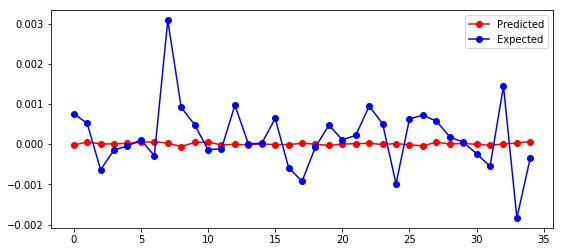

SVR


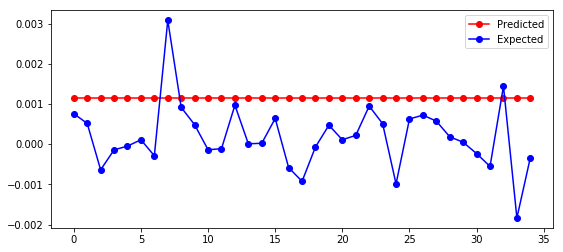

,volume,diff closeMid,diff highMid,diff lowMid,diff openMid,volume5,diff openMid5,diff closeMid5,diff lowMid5,diff highMid5,diff openMid10,diff closeMid10,diff lowMid10,diff highMid10,diff closeMid15,diff lowMid15,diff highMid15,volume20,diff openMid20,diff lowMid20,diff highMid20,volume25,diff openMid25,diff lowMid25,diff highMid25,diff closeMid30,diff lowMid30,diff highMid30,volume35,diff closeMid35,diff lowMid35,diff highMid35,diff openMid40,diff lowMid40,diff highMid40,diff openMid45,diff lowMid45,diff highMid45,volume50,diff openMid50,diff lowMid50,diff highMid50,diff openMid55,diff closeMid55,diff lowMid55,diff highMid55,volume60,diff openMid60,diff closeMid60,diff lowMid60,diff highMid60,H,L,vol,polarity,subjectivity,intercept,future diff high
0,16,-0.000474,0.000000,-0.000313,0.000179,22.0,0.000161,0.000161,0.000224,0.000152,-0.000340,0.000152,-0.000045,-0.000134,-0.000420,-0.000376,-0.000286,18.0,0.000000,0.000000,0.000000,19.0,0.000045,-0.000268,-0.000045,0.000000,0.000134,0.000045,37.0,0.000000,-0.000179,-0.000134,0.000045,0.000125,0.000134,0.000045,0.000063,0.000018,37.0,0.000000,-0.000009,0.000036,0.000089,0.000000,0.000224,0.000036,33.0,0.000510,0.000089,0.000313,-0.000223,0.000510,-0.000474,314.0,-0.2,0.25,1,0.000224
1,11,-0.000179,0.000000,-0.000089,0.000000,16.0,-0.000045,0.000000,-0.000081,-0.000089,0.000179,0.000000,0.000125,0.000045,0.000179,0.000134,0.000134,24.0,-0.000358,0.000045,-0.000268,33.0,0.000224,-0.000134,0.000000,0.000224,0.000000,0.000152,26.0,0.000000,-0.000081,-0.000152,0.000045,-0.000170,-0.000179,-0.000072,0.000000,0.000134,17.0,0.000045,0.000000,-0.000027,-0.000492,0.000027,0.000000,-0.000376,16.0,0.000179,-0.000474,-0.000313,0.000000,0.000224,-0.000492,264.0,-0.2,0.25,1,0.000763
2,44,0.000045,-0.000135,0.000386,0.000538,79.0,0.000539,0.000538,0.000718,0.000763,-0.000898,0.000494,-0.000045,-0.000314,-0.000727,-0.000826,-0.001031,105.0,-0.000896,-0.001184,-0.001030,80.0,-0.000090,-0.000994,-0.000313,0.000000,0.000179,0.000134,31.0,-0.000313,-0.000403,-0.000090,-0.000179,0.000045,-0.000090,-0.000089,-0.000269,-0.000179,19.0,-0.000045,0.000045,0.000045,-0.000134,0.000000,-0.000134,-0.000134,11.0,0.000000,-0.000179,-0.000089,0.000000,0.000763,-0.001184,587.0,-0.2,0.25,1,0.000538
3,63,0.000224,-0.000090,-0.000054,-0.000045,56.0,0.000045,0.000000,0.000054,0.000179,0.000269,0.000000,0.000224,0.000090,0.000224,0.000090,0.000045,42.0,-0.000224,-0.000090,0.000135,33.0,-0.000090,-0.000179,-0.000179,0.000000,0.000090,0.000045,25.0,0.000000,0.000000,-0.000457,0.000045,-0.000314,-0.000036,-0.000072,0.000314,0.000242,72.0,-0.000135,-0.000386,-0.000179,0.000027,-0.000242,0.000000,-0.000018,44.0,0.000538,0.000045,0.000386,-0.000135,0.000538,-0.000457,533.0,-0.2,0.25,1,0.001029
4,110,0.000805,0.001029,0.000761,0.000716,88.0,0.000224,0.000689,0.000251,0.000627,0.000538,0.000161,0.000466,0.000224,0.000538,-0.000090,0.000134,49.0,0.000090,-0.000224,-0.000027,60.0,-0.000090,0.000045,-0.000242,-0.000045,0.000448,0.000358,52.0,0.000538,-0.000009,-0.000403,0.000502,-0.000305,0.000045,0.000466,0.000403,0.000448,59.0,0.000502,0.000493,0.000385,0.000188,0.000511,0.000224,0.000601,63.0,-0.000045,0.000224,-0.000054,-0.000090,0.001029,-0.000941,736.0,-0.2,0.25,1,0.001029


,future diff high
L,-0.397177
diff lowMid30,-0.043643
diff lowMid60,-0.037262
diff lowMid45,-0.035494
diff highMid25,-0.024622
diff highMid55,-0.021570
diff openMid40,-0.021496
diff highMid15,-0.019511
diff openMid45,-0.019265
diff highMid40,-0.018272


H
LINREG


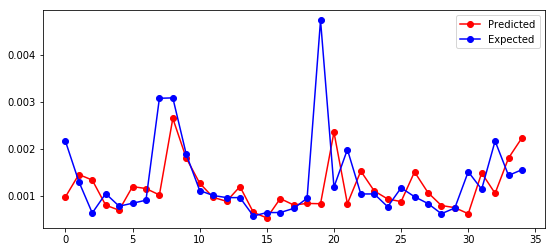

SVR


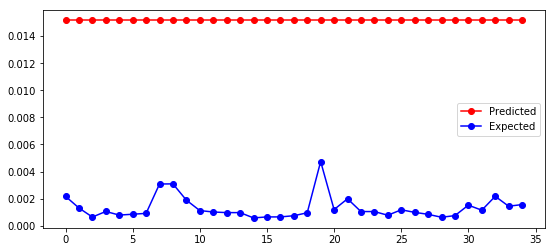

,volume,diff closeMid,diff highMid,diff lowMid,diff openMid,volume5,diff openMid5,diff closeMid5,diff lowMid5,diff highMid5,diff openMid10,diff closeMid10,diff lowMid10,diff highMid10,diff closeMid15,diff lowMid15,diff highMid15,volume20,diff openMid20,diff lowMid20,diff highMid20,volume25,diff openMid25,diff lowMid25,diff highMid25,diff closeMid30,diff lowMid30,diff highMid30,volume35,diff closeMid35,diff lowMid35,diff highMid35,diff openMid40,diff lowMid40,diff highMid40,diff openMid45,diff lowMid45,diff highMid45,volume50,diff openMid50,diff lowMid50,diff highMid50,diff openMid55,diff closeMid55,diff lowMid55,diff highMid55,volume60,diff openMid60,diff closeMid60,diff lowMid60,diff highMid60,H,L,vol,polarity,subjectivity,intercept,future diff low
0,16,-0.000474,0.000000,-0.000313,0.000179,22.0,0.000161,0.000161,0.000224,0.000152,-0.000340,0.000152,-0.000045,-0.000134,-0.000420,-0.000376,-0.000286,18.0,0.000000,0.000000,0.000000,19.0,0.000045,-0.000268,-0.000045,0.000000,0.000134,0.000045,37.0,0.000000,-0.000179,-0.000134,0.000045,0.000125,0.000134,0.000045,0.000063,0.000018,37.0,0.000000,-0.000009,0.000036,0.000089,0.000000,0.000224,0.000036,33.0,0.000510,0.000089,0.000313,-0.000223,0.000510,-0.000474,314.0,-0.2,0.25,1,-0.000492
1,11,-0.000179,0.000000,-0.000089,0.000000,16.0,-0.000045,0.000000,-0.000081,-0.000089,0.000179,0.000000,0.000125,0.000045,0.000179,0.000134,0.000134,24.0,-0.000358,0.000045,-0.000268,33.0,0.000224,-0.000134,0.000000,0.000224,0.000000,0.000152,26.0,0.000000,-0.000081,-0.000152,0.000045,-0.000170,-0.000179,-0.000072,0.000000,0.000134,17.0,0.000045,0.000000,-0.000027,-0.000492,0.000027,0.000000,-0.000376,16.0,0.000179,-0.000474,-0.000313,0.000000,0.000224,-0.000492,264.0,-0.2,0.25,1,-0.001184
2,44,0.000045,-0.000135,0.000386,0.000538,79.0,0.000539,0.000538,0.000718,0.000763,-0.000898,0.000494,-0.000045,-0.000314,-0.000727,-0.000826,-0.001031,105.0,-0.000896,-0.001184,-0.001030,80.0,-0.000090,-0.000994,-0.000313,0.000000,0.000179,0.000134,31.0,-0.000313,-0.000403,-0.000090,-0.000179,0.000045,-0.000090,-0.000089,-0.000269,-0.000179,19.0,-0.000045,0.000045,0.000045,-0.000134,0.000000,-0.000134,-0.000134,11.0,0.000000,-0.000179,-0.000089,0.000000,0.000763,-0.001184,587.0,-0.2,0.25,1,-0.000457
3,63,0.000224,-0.000090,-0.000054,-0.000045,56.0,0.000045,0.000000,0.000054,0.000179,0.000269,0.000000,0.000224,0.000090,0.000224,0.000090,0.000045,42.0,-0.000224,-0.000090,0.000135,33.0,-0.000090,-0.000179,-0.000179,0.000000,0.000090,0.000045,25.0,0.000000,0.000000,-0.000457,0.000045,-0.000314,-0.000036,-0.000072,0.000314,0.000242,72.0,-0.000135,-0.000386,-0.000179,0.000027,-0.000242,0.000000,-0.000018,44.0,0.000538,0.000045,0.000386,-0.000135,0.000538,-0.000457,533.0,-0.2,0.25,1,-0.000941
4,110,0.000805,0.001029,0.000761,0.000716,88.0,0.000224,0.000689,0.000251,0.000627,0.000538,0.000161,0.000466,0.000224,0.000538,-0.000090,0.000134,49.0,0.000090,-0.000224,-0.000027,60.0,-0.000090,0.000045,-0.000242,-0.000045,0.000448,0.000358,52.0,0.000538,-0.000009,-0.000403,0.000502,-0.000305,0.000045,0.000466,0.000403,0.000448,59.0,0.000502,0.000493,0.000385,0.000188,0.000511,0.000224,0.000601,63.0,-0.000045,0.000224,-0.000054,-0.000090,0.001029,-0.000941,736.0,-0.2,0.25,1,-0.001120


,future diff low
H,-0.362068
volume,-0.267021
volume5,-0.205935
vol,-0.205350
volume20,-0.197408
volume25,-0.189333
volume35,-0.181993
volume50,-0.172222
volume60,-0.138067
subjectivity,-0.048483


L
LINREG


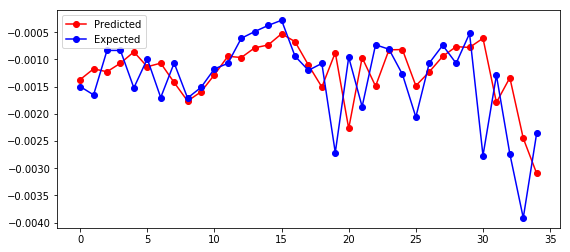

SVR


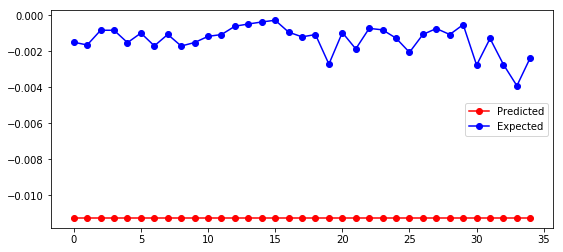

In [24]:
if pricediff:
    Actuals = ['diff closeMid', 'H', 'L']
    Responses = ['future diff close', 'future diff high', 'future diff low']

else:
    Actuals = ['closeMid', 'H', 'L']
    Responses = ['future close', 'future high', 'future low']

intercept = True
models = {}
prints = 35

for actual,response in zip(Actuals, Responses):
    df = DF.copy()
    df[response] = df[actual].shift(-1)
    df = df.dropna()
    display(df.head())
    display(df.corr()[[response]].sort_values(response))
    X_train, X_test, y_train, y_test = train_test(df, response, train_size=0.75, time_series=True, scaling=None)
    
    if intercept:
        X_train = sm.add_constant(X_train, prepend=True, has_constant='skip')
        X_test = sm.add_constant(X_test, prepend=True, has_constant='skip')

    lr = linreg(X_train, y_train)
    svr = SVR()
    svr.fit(X_train, y_train) 
    models["Linreg_{}".format(actual)] = lr
    models["SVR_{}".format(actual)] = svr
    print(actual)
    plt.figure(figsize=(9,4))
    print('LINREG')
    plt.plot(range(len(y_test[:prints])),lr.predict(X_test[:prints]), color='r', marker='o', label='Predicted')
    plt.plot(range(len(y_test[:prints])),y_test[:prints], color='b', marker='o', label='Expected')
    plt.legend()
    plt.show()
    plt.figure(figsize=(9,4))
    print('SVR')
    plt.plot(range(len(y_test[:prints])),svr.predict(X_test[:prints]), color='r', marker='o', label='Predicted')
    plt.plot(range(len(y_test[:prints])),y_test[:prints], color='b', marker='o', label='Expected')
    plt.legend()
    plt.show()

In [101]:
models

{'Linreg_H': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f681f2d6d68>,
 'Linreg_L': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f681f5e5470>,
 'Linreg_diff closeMid': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f6825dec0f0>}

# Backtesting

In [53]:
model = 'Linreg'

In [74]:
bt = pd.DataFrame()
for actual,response in zip(Actuals, Responses):
    df = DF.copy()
    df[response] = df[actual].shift(-1)
    X_train, X_test, y_train, y_test = train_test(df, response, train_size=0.75, time_series=True, scaling=None)
    if intercept:
        X_train = sm.add_constant(X_train, prepend=True, has_constant='skip')
        X_test = sm.add_constant(X_test, prepend=True, has_constant='skip')
    mod = models['{}_{}'.format(model, actual)]
    bt['Expected ' + actual] = y_test
    bt['Predicted ' + actual] = mod.predict(X_test)

In [75]:
for i in bt.columns:
    bt[i] = np.exp(bt[i])

In [86]:
#for i in bt.columns:
#    bt[i] = round(bt[i], 5)
bt['win high'] = bt['Predicted H'] - 0.0005 <= bt['Expected H']
bt['win low'] = bt['Predicted L'] + 0.001 >= bt['Expected L'] 

In [87]:
len(bt[bt['win high']])

16296

In [ ]:
############################3

In [77]:
bt['win change high'] = 0
bt.loc[(bt['win high']), 'win change high'] = round(bt['Predicted H'] - 0.02 - bt['Expected diff closeMid'].shift(1), 4)
bt.loc[(bt['win high'] != True), 'win change high'] = round(bt['Expected diff closeMid'].shift(1) - bt['Predicted L'] - 0.02, 4)
bt['win change low'] = 0
bt.loc[(bt['win low']), 'win change low'] = round(bt['Expected diff closeMid'].shift(1) - bt['Predicted L'] + 0.02, 4)
bt.loc[(bt['win low'] != True), 'win change low'] = round(bt['Expected diff closeMid'].shift(1) - bt['Predicted H'] + 0.02, 4)
bt = bt.dropna()

# Trading

In [ ]:
response = oanda.get_history(instrument="USD_JPY", granularity='M5', since='2018-11-01')

a = pd.DataFrame(response['candles'])